In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle # para leer los archivos comprimidos (.p)
#%pip install matplotlib
#%pip install mpl-interactions
#%pip install ipympl
from IPython.core.display import display, HTML
#remove paddingss
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))
#parameters#####################
nsensores =3 # 1 a 4
SampleFreq=1400
nombreArchivo = './mediciones/07112023_3s______ok.p' #26102023.p' #'./datos/3sens_130423_2.p' #  './datos/oclusion_bien.p'

#############################

with open(nombreArchivo, 'rb') as f:
    data = pickle.load(f)
    print("Datos extraidos de %s" %nombreArchivo)
    f.close()
    
s0_raw = data['sensor0']
if nsensores >= 2 :    s1_raw = data['sensor1']
if nsensores >= 3 :    s2_raw = data['sensor2']
if nsensores >= 4 :    s3_raw = data['sensor3']

n_samples = len(s0_raw) #1.5*60*2000 #min*60*fsamp

<IPython.core.display.Javascript object>


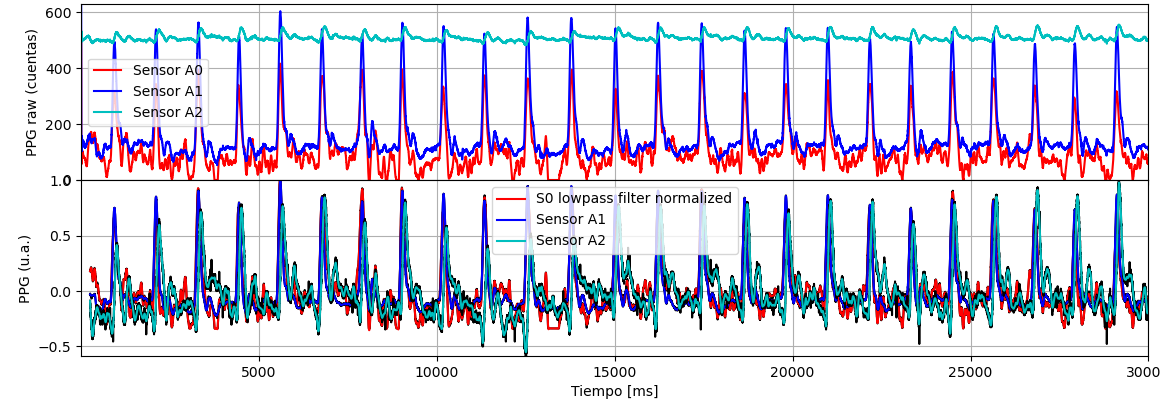

In [2]:
#preprocesamiento: normalizo y filtro señales

#enables zoom on figs:
%matplotlib notebook 

#-parameters-------------------------------------------------------------------
t_sec_discarded = 0.250
lp_cutoff_hz = 20      # desired cutoff frequency of the filter, Hz ,
lp_order = 3


# grafico señales sin procesar-----------------------------------------------------
fig = plt.figure(figsize = (11.6, 4)); ax0 = plt.subplot(211); ax0.margins(0, 0) #fig.suptitle('test title', fontsize=20)
SampleFreqKHz = SampleFreq/1000
#time_raw = np.arange(0, n_samples/SampleFreqKHz, 1/SampleFreqKHz) #; time = time[:n_samples]  #start stop step
time_raw = np.linspace(1/SampleFreqKHz, n_samples/SampleFreqKHz, n_samples) #; time = time[:n_samples]  #start stop step
#numpy.linspace start stop num
plt.plot(time_raw, s0_raw, 'r', label="Sensor A0")
if nsensores >= 2 :    plt.plot(time_raw, s1_raw, 'b', label="Sensor A1")
if nsensores >= 3 :    plt.plot(time_raw, s2_raw, 'c', label="Sensor A2")
if nsensores >= 4 :    plt.plot(time_raw, s3_raw, 'g', label="Sensor A3")
plt.xlabel("Tiempo [ms]"), plt.ylabel("PPG raw (cuentas)")#, plt.title("Señales ")
plt.legend(), plt.grid(), plt.setp(ax0.get_xticklabels(), visible=False), plt.show()

# normalizo y filtro #####################################################################

#descarto primeras muestras--
n_discarded = round(t_sec_discarded*SampleFreq) #
s0_trunc = s0_raw[n_discarded:] 
time = time_raw[n_discarded:] 
if nsensores >= 2 :    s1_trunc = s1_raw[n_discarded:] 
if nsensores >= 3 :    s2_trunc = s2_raw[n_discarded:] 
if nsensores >= 4 :    s3_trunc = s3_raw[n_discarded:] 

#filtro PB---------------------------------------------    
from scipy.signal import butter,filtfilt
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = lp_cutoff_hz / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)# Get the filter coefficients 
    y = filtfilt(b, a, data)
    return y

# normalizo  datos.--------------------------------------------
# resto valor medio y divido por el max
ax1 = plt.subplot(212, sharex = ax0); ax1.margins(0, 0)
s0_mean = s0_trunc - round(np.mean(s0_trunc)); 
s0_norm = s0_mean/np.max(s0_mean);# s0_nf = s0
plt.plot(time, s0_norm, 'k')
s0 = butter_lowpass_filter(s0_norm, lp_cutoff_hz, SampleFreq, order=lp_order)
plt.plot(time, s0, 'r', label="S0 lowpass filter normalized")
if nsensores >= 2 :
    s1_mean = s1_trunc - round(np.mean(s1_trunc));    
    s1_norm = s1_mean/np.max(s1_mean); #   s1_nf = s1;
    plt.plot(time, s1_norm, 'k')
    s1 = butter_lowpass_filter(s1_norm, lp_cutoff_hz, SampleFreq, order=lp_order)
    plt.plot(time, s1, 'b', label="Sensor A1")
if nsensores >= 3 :
    s2_mean = s2_trunc - round(np.mean(s2_trunc));     
    s2_norm = s2_mean/np.max(s2_mean);  # s2_nf = s2;
    s2 = butter_lowpass_filter(s2_norm, lp_cutoff_hz, SampleFreq, order=lp_order)
    plt.plot(time, s2_norm, 'k')
    plt.plot(time, s2, 'c', label="Sensor A2")
if nsensores >= 4 :
    s3_mean = s3_trunc - round(np.mean(s3_trunc));     
    s3_norm = s3_mean/np.max(s3_mean);  #   s3_nf = s3;
    s3 = butter_lowpass_filter(s3_norm, lp_cutoff_hz, SampleFreq, order=lp_order)
    plt.plot(time, s3_norm, 'k')
    plt.plot(time, s3, 'g', label="Sensor A3")

plt.xlabel("Tiempo [ms]"), plt.ylabel("PPG (u.a.)")#, plt.title("Señales normalizadas")
plt.legend(), plt.grid(), plt.subplots_adjust(hspace=.0) # remove vertical gap between subplots
plt.subplots_adjust(left=0.07, right=.99, top=.99, bottom=.11)
plt.show()



<IPython.core.display.Javascript object>


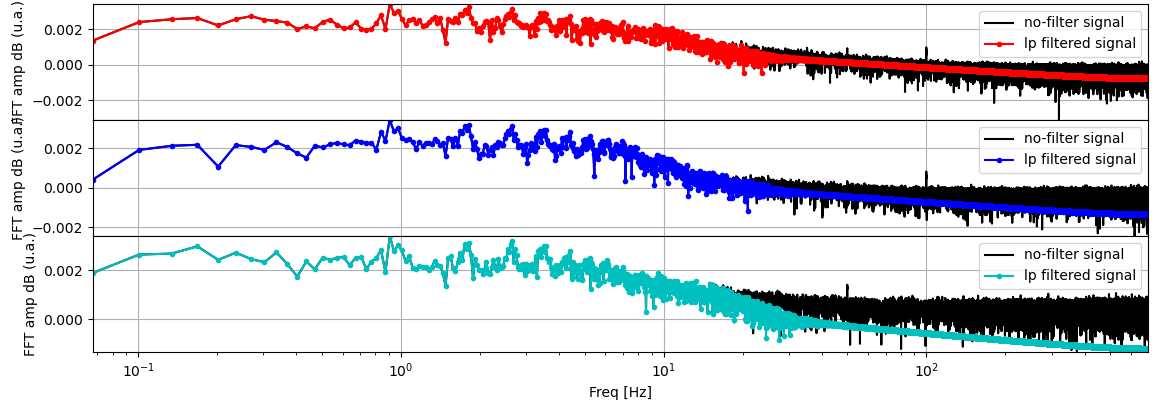

In [3]:
from scipy.fft import fft, fftfreq

N = len(s0)  #freq points
yf = fft(s0)
yf_nf=  fft(s0_norm) 
xf = np.linspace(SampleFreq/(N//2), SampleFreq//2, N//2, endpoint=False)

fig = plt.figure(figsize = (11.6, 4)); 
ax0 = plt.subplot(nsensores,1,1); ax0.margins(0, 0) #fig.suptitle('test title', fontsize=20)
#ax1 = plt.subplot(2,1,1) 
#ax0 = plt.figure(figsize = (11.6, 4));  #ax0.margins(0, 0) #fig.suptitle('test title', fontsize=20)
plt.subplots_adjust(left=0.08, right=.99, top=.99, bottom=.12)
plt.plot(xf, 2.0/N * 20 * np.log10(np.abs(yf_nf[0:N//2])),'k', label="no-filter signal")
plt.plot(xf, 2.0/N * 20 * np.log10(np.abs(yf[0:N//2])), 'r',marker=".", label="lp filtered signal")
plt.xscale('log'), plt.grid(), plt.xlabel("Freq [Hz]"), plt.ylabel("FFT amp dB (u.a.)"), plt.legend(), plt.show();

if nsensores >= 2 :  
    N = len(s1)  #freq points
    yf = fft(s1)
    yf_nf=  fft(s1_norm) 
    #ax1 = plt.figure(figsize = (11.6, 4), sharex = ax0); #ax1 = plt.subplot(211); ax0.margins(0, 0) #fig.suptitle('test title', fontsize=20)
    #ax1 = plt.subplot(212, sharex = ax0); ax1.margins(0, 0)
    #ax1 = plt.subplot(211) 
    #plt.show();
    ax1 = plt.subplot(nsensores,1,2, sharex = ax0); ax1.margins(0, 0);
    #fig = plt.figure(figsize = (11.6, 4));  ax0.margins(0, 0) #fig.suptitle('test title', fontsize=20)
    plt.subplots_adjust(left=0.08, right=.99, top=.99, bottom=.12)
    plt.plot(xf, 2.0/N * 20 * np.log10(np.abs(yf_nf[0:N//2])),'k', label="no-filter signal")
    plt.plot(xf, 2.0/N * 20 * np.log10(np.abs(yf[0:N//2])),'b', marker=".", label="lp filtered signal")
    plt.xscale('log'), plt.grid(), plt.xlabel("Freq [Hz]"), plt.ylabel("FFT amp dB (u.a.)"), plt.legend(), plt.show();

if nsensores >= 3 :  
    N = len(s2)  #freq points
    yf = fft(s2)
    yf_nf=  fft(s2_norm) 
    ax2 = plt.subplot(nsensores,1,3, sharex = ax0); ax2.margins(0, 0)
    #ax2 = plt.figure(figsize = (11.6, 4));  #ax0.margins(0, 0) #fig.suptitle('test title', fontsize=20)
    plt.subplots_adjust(left=0.08, right=.99, top=.99, bottom=.12)
    plt.plot(xf, 2.0/N * 20 * np.log10(np.abs(yf_nf[0:N//2])),'k', label="no-filter signal")
    plt.plot(xf, 2.0/N * 20 * np.log10(np.abs(yf[0:N//2])),'c', marker=".", label="lp filtered signal")
    plt.xscale('log'), plt.grid(), plt.xlabel("Freq [Hz]"), plt.ylabel("FFT amp dB (u.a.)"), plt.legend(), plt.show();
    
plt.subplots_adjust(hspace=.0) # remove vertical gap between subplots

[-78.57142857 -70.         -72.85714286 -61.42857143 -93.57142857
 -70.71428571 -90.71428571 -95.         -94.28571429 -78.57142857
 -77.14285714 -72.85714286 -78.57142857 -74.28571429 -77.14285714
 -62.14285714 -83.57142857 -64.28571429 -65.71428571 -87.14285714
 -69.28571429 -70.         -68.57142857]
[ -57.14285714  -60.          -65.71428571  -58.57142857  -61.42857143
  -90.          -62.85714286  -86.42857143  -90.71428571  -77.85714286
  -68.57142857  -59.28571429  -58.57142857  -75.          -56.42857143
  -62.14285714  -43.57142857  -82.85714286  -54.28571429  -57.85714286
  -88.57142857  -66.42857143  -67.14285714 -107.14285714]
[  0.   -70.71 -74.46 -74.64 -79.11 -87.5  -87.68 -89.64 -86.25 -80.71
 -76.79 -75.71 -75.71 -73.04 -74.29 -71.79 -68.93 -75.18 -71.61 -73.04
 -73.75   0.     0.  ]
[  0.   -60.36 -61.43 -68.93 -68.21 -75.18 -82.5  -79.46 -80.89 -74.11
 -66.07 -65.36 -62.32 -63.04 -59.29 -61.25 -60.71 -59.64 -70.89 -66.79
 -70.   -82.32   0.     0.  ]


<IPython.core.display.Javascript object>


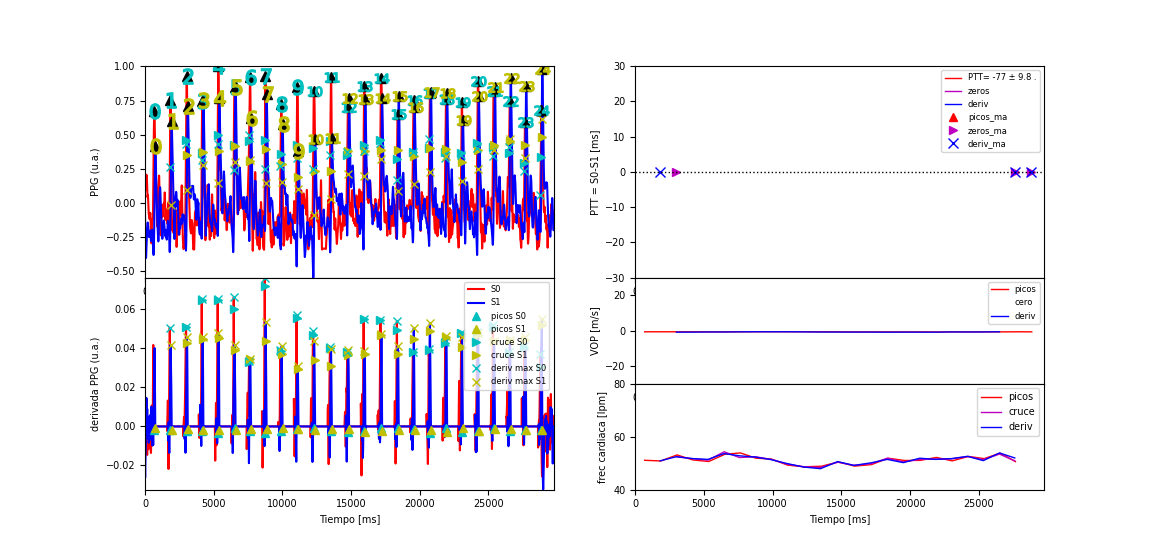

C:\Users\Leonardo Casal\AppData\Local\Temp\ipykernel_14476\2834140315.py:331: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(time_ms[last_zeros_crossing_array0],  DISTANCIA_mts*1000/delta_T_zeros_ma, 'm-', label='cero', lw=.0)   #  ptt detectada con cruce por cero
C:\Users\Leonardo Casal\AppData\Local\Temp\ipykernel_14476\2834140315.py:332: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(time_ms[deriv_max_array0],            DISTANCIA_mts*1000/delta_T_deriv_ma, 'b-', label='deriv', lw=1.0)      #  ptt detectada con reconstrucción derivada


((40.0, 80.0),
 <function matplotlib.pyplot.show(block=None)>)

In [38]:
#aplico filtro media movil, detecto picos, descarto picos sin pareja
#buscamos cruce por cero, derivada
#descarto latidos borde
#calculo delta_T de diferentes maneras
#calculo frec de diferentes maneras
#aplico filtro media movil a delta T
#calculo VOP
#grafico

#DISTANCIA_mts=0.36 #0.36 .04y 0.08 # VOP VELOCIDAD DE ONDA DE PULSO--------------

DISTANCIA_mts=0.05 #.47 codo punta dedo// 0.26codo muñeca // .21 muñeca punta dedo dedo a dedod .055 #0.36 .04y 0.08 # VOP VELOCIDAD DE ONDA DE PULSO--------------

#s0_aux = s0
#s1_aux = s1
#s2_aux = s2
#
#s1 = s2

#DETECTOR DE PICOS-------------------------------------------------------------------------------------------------------
from scipy.signal import find_peaks
# minimum height for a peak to be recognized.
# minimum distance for a peak to be recognized.
#peaks_min_time_ms = 900/SampleFreqKHz # = 450 ms -> 60/.450 = 133 bpm max_bpm = 60/(distance/SampleFreq_Hz)  60*2000/133
bpm_max = 133
distance = round(60*SampleFreq/bpm_max) #min peak distance
#peaks0, _ = find_peaks(s2, distance=distance,height=0.1, width=50)
#peaks1, _ = find_peaks(s0, distance=distance,height=0.1, width=50)# rojo

# DETECTOR DE PICOS sobre la señal con filtrada CON MEDIA MÓVIL
peaks0_ma, _ = find_peaks(s0, distance=distance,height=0.1, width=50)
peaks1_ma, _ = find_peaks(s1, distance=distance,height=0.1, width=50)# rojo

peaks0 = peaks0_ma;
peaks1 = peaks1_ma;

#print(peaks0/SampleFreq)
#print(peaks1/SampleFreq)
"""
beats_power_array0 = np.zeros(len(peaks0_ma)-2);
for n_beat in range(1,len(peaks0_ma)-1):
    latido = s0[peaks0_ma[n_beat]:peaks0_ma[n_beat+1]] 
    beats_power_array0[n_beat-1] = np.abs(latido)**2

np.power(x1, 3)
"""

#discard peaks with no matching peak at both signals (when difference is greater than 100ms)
ptt_max_ms = 100       
i = -1
#for j in range(0,min(len(peaks1_ma),len(peaks0_ma))):
while  i< min(len(peaks1_ma),len(peaks0_ma))-1:
    i = i+1
    #print("j: " + str(j) + " len(peaks1_ma)=" + str(len(peaks1_ma)) + ", len(peaks1_ma)= " + str(len(peaks1_ma)))
    #print("j: " + str(j)+ " len(peaks1_ma)=" + str(len(peaks1_ma))
    #print(i)
    #print(peaks0_ma[i])
    if abs(peaks0_ma[i] - peaks1_ma[i])/SampleFreqKHz > ptt_max_ms: #peak1 with beat, peak0 no beat 
        if peaks0_ma[i] < peaks1_ma[i]:
            #print("discarded peak after beat nr "+str(i-1)+" at "+str(peaks0_ma[i]/SampleFreq)+" for signal 0 (next peak at signal1 was at "+str(peaks1_ma[i]/SampleFreq)+" >100ms after beat at signal0)")
            peaks0_ma[i:-1] = peaks0_ma[i+1:] #discard beat with no matching beat
            peaks0_ma = peaks0_ma[:-1] #and discard last beat (repeated)
        else :
            #print("discarded peak after beat nr "+str(i-1)+" at "+str(peaks1_ma[i]/SampleFreq)+" for signal 1 (next peak at signal0 was at "+str(peaks0_ma[i]/SampleFreq)+" >100ms after beat at signal1)")
            peaks1_ma[i:-1] = peaks1_ma[i+1:] #discard beat with no matching beat
            peaks1_ma = peaks1_ma[:-1] #and discard last beat (repeated), achico array
        i = i-1 #dont increase beat if theres no match
    #else: print("beat nr "+str(i)+" at "+str(peaks1_ma[i]/SampleFreq)+" for signal 1 and "+str(peaks0_ma[i]/SampleFreq)+" signal0, diff="+str(peaks0_ma[i]-peaks1_ma[i]) )
#print(peaks0_ma/SampleFreq)
#print(peaks1_ma/SampleFreq)    
"""
    if (peaks0_ma[i] - peaks1_ma[i])/SampleFreqKHz > 100: #peak1 with beat, peak0 no beat 
        print("discarded peak nr "+str(j)+" at "+str(peaks1_ma[i])+" for signal 1 (beat at signal0 was >100ms after beat at signal1)")
        peaks1_ma[i:-1] = peaks1_ma[i+1:] #discard beat with no matching beat
        #i = i-1 #dont increase beat if theres no match
        peaks1_ma = peaks1_ma[:-1] #discard last beat, achico array
    if (peaks1_ma[i] - peaks0_ma[i])/SampleFreqKHz > 100:  #peak0 with beat, peak1 no beat 
        #peaks0 = peaks0[1:] 
        print("discarded peak nr "+str(j)+" at "+str(peaks0_ma[i])+" for signal 0 (beat at signal1 was >100ms after beat at signal0)")
        peaks0_ma[i:-1] = peaks0_ma[i+1:] #discard beat with no matching beat
        peaks0_ma = peaks0_ma[:-1] #discard last beat, achico array
        #i = i-1
"""
   
#-buscamos cruce por cero-----------------------------------------------------------------------
last_zeros_crossing_array0 = np.zeros(len(peaks0_ma)-2);
len_beat_prev = peaks0_ma[1];
for n_beat in range(1,len(peaks0_ma)-1):
    latido = s0[peaks0_ma[n_beat]:peaks0_ma[n_beat+1]] 
    latido = latido - .5*s0[peaks0_ma[n_beat+1]]  #((np.max(latido)-np.min(latido))
    zero_crossings = np.where(np.diff(np.sign(latido)))[0]
    if len(zero_crossings) > 0:
        last_zeros_crossing_array0[n_beat-1] = int(len_beat_prev + zero_crossings[-1])
    len_beat_prev = len_beat_prev + len(latido)
last_zeros_crossing_array0 = last_zeros_crossing_array0.astype(int)

last_zeros_crossing_array1 = np.zeros(len(peaks1_ma)-2);
len_beat_prev = peaks1_ma[1];
for n_beat in range(1,len(peaks1_ma)-1):
    latido = s1[peaks1_ma[n_beat]:peaks1_ma[n_beat+1]]   
    latido = latido - .5*s1[peaks1_ma[n_beat+1]]  #(np.max(latido)-np.min(latido))
    zero_crossings = np.where(np.diff(np.sign(latido)))[0]
    if len(zero_crossings) > 0:
        last_zeros_crossing_array1[n_beat-1] = int(len_beat_prev + zero_crossings[-1])
    len_beat_prev = len_beat_prev + len(latido)
last_zeros_crossing_array1 = last_zeros_crossing_array1.astype(int)

# calculamos derivada #####
deriv_window_time_ms = 250 # ventana temporal sistolica (desde pico del latido) donde busco maxima derivada
n_deriv_samples = 5# 120 #14.9 50, 15 70, 12.3 100, 11.7 110, 9.7 115, 8.8 120, 11.5 130, 11.3 150,11.6 170, 11.2 200, 17.2 250 
deriv0 =  s0[n_deriv_samples:] - s0[:-n_deriv_samples]
# buscamos el max dentro de cada latido #####
#deriv_max_array0 = np.zeros(len(peaks0_ma)-1);
deriv_max_array0 = []
len_beat_prev = peaks0_ma[0]; #si ponemos cero no coincide el pico con el maximo en el grafico
for n_beat in range(0,len(peaks0_ma)-1):
    latido_len = len(deriv0[peaks0_ma[n_beat]:peaks0_ma[n_beat+1]])
    #buscar maxima derivada desde el pico de ppg  y la mitad del latido
    deriv0[peaks0_ma[n_beat]+1:peaks0_ma[n_beat+1]-round(deriv_window_time_ms/1000*SampleFreq)] = 0
#    deriv0[peaks0_ma[n_beat]+1:round((peaks0_ma[n_beat]+peaks0_ma[n_beat+1])/frac_time_deriv+200)] = 0
    latido_deriv = deriv0[peaks0_ma[n_beat]:peaks0_ma[n_beat+1]] 
    deriv_max0 = np.argmax(latido_deriv)
    #deriv_max_array0[n_beat-1] = int(len_beat_prev + deriv_max0)
    deriv_max_array0.append(int(len_beat_prev + deriv_max0))
    len_beat_prev = len_beat_prev + latido_len
#deriv_max_array0 = deriv_max_array0.astype(int)
deriv_max_array0 =  np.array(deriv_max_array0)

deriv1 =  s1[n_deriv_samples:] - s1[:-n_deriv_samples]
#deriv_max_array1 = np.zeros(len(peaks1_ma)-1);
deriv_max_array1 = []
len_beat_prev = peaks1_ma[0];
for n_beat in range(0,len(peaks1_ma)-1):
    latido_len = len(deriv1[peaks1_ma[n_beat]:peaks1_ma[n_beat+1]])
    deriv1[peaks1_ma[n_beat]+1:peaks1_ma[n_beat+1]-round(deriv_window_time_ms/1000*SampleFreq)] = 0
#    deriv1[peaks1_ma[n_beat]+1:round((peaks1_ma[n_beat]+peaks1_ma[n_beat+1])/frac_time_deriv+200)] = 0
    latido_deriv = deriv1[peaks1_ma[n_beat]:peaks1_ma[n_beat+1]] 
    deriv_max1 = np.argmax(latido_deriv)
    #deriv_max_array1[n_beat-1] = int(len_beat_prev + deriv_max1)
    deriv_max_array1.append(int(len_beat_prev + deriv_max1))
    len_beat_prev = len_beat_prev + latido_len
#deriv_max_array1 = deriv_max_array1.astype(int)
deriv_max_array1 =  np.array(deriv_max_array1)

    
#corrijo indices para que todos los vectores tengasn la misma longitud#################
"""len0 = min(len(peaks1),len(peaks0),len(peaks1_ma),len(peaks0_ma)) - 1
#len0 = min(len(peaks1),len(peaks0))
#peaks0 = peaks0[:min(len(peaks1),len(peaks0))]
#peaks1 = peaks1[:min(len(peaks1),len(peaks0))]
#len0 = min(len(peaks1_ma),len(peaks0_ma))
peaks0_ma = peaks0_ma[:min(len(peaks1_ma),len(peaks0_ma))]
peaks1_ma = peaks1_ma[:min(len(peaks1_ma),len(peaks0_ma))]

len0 = min(len(last_zeros_crossing_array0),len(last_zeros_crossing_array1))
last_zeros_crossing_array0 = last_zeros_crossing_array0[:len0]
last_zeros_crossing_array1 = last_zeros_crossing_array1[:len0]

len0 = min(len(deriv_max_array0),len(deriv_max_array1))
deriv_max_array0 = deriv_max_array0[:len0]
deriv_max_array1 = deriv_max_array1[:len0]
"""

# CUENTO LATIDOS frec cardiaca---------------------------------------------------------------------------------------------------------
heart_period_samples = abs(peaks1[:-1] - peaks1[1:])
heart_period_ms = heart_period_samples/SampleFreqKHz #conivierto muestras a tiempo
frec0 = 60*1000/heart_period_ms #convierto ms a minutos

heart_period_samples_ma = abs(peaks0_ma[:-1] - peaks0_ma[1:])
heart_period_ms_ma  = heart_period_samples_ma /SampleFreqKHz #conivierto muestras a tiempo
frec0_ma  = 60*1000/heart_period_ms_ma  #convierto ms a minutos

heart_period_samples_ma = abs(last_zeros_crossing_array0[:-1] - last_zeros_crossing_array0[1:])
heart_period_ms_ma  = heart_period_samples_ma /SampleFreqKHz #conivierto muestras a tiempo
frec0_zero_ma  = 60*1000/heart_period_ms_ma  #convierto ms a minutos

heart_period_samples_ma = abs(deriv_max_array0[:-1] - deriv_max_array0[1:])
heart_period_ms_ma  = heart_period_samples_ma /SampleFreqKHz #conivierto muestras a tiempo
frec0_deriv_ma  = 60*1000/heart_period_ms_ma  #convierto ms a minutos


# PULSE TRANSIT TIME ----PTT---------------------------------------------------------------------------------------------
#calculo delta T ############
#delta_T = (peaks0 - peaks1)/SampleFreqKHz
delta_T_ma = (peaks0_ma - peaks1_ma)/SampleFreqKHz
delta_T_zeros = (last_zeros_crossing_array0 - last_zeros_crossing_array1)/SampleFreqKHz
delta_T_deriv = (deriv_max_array0 - deriv_max_array1)/SampleFreqKHz
#discard delta_T higher than 100ms (found beat on one signal but not in the other)
#for n_beat in range(2,len(delta_T_zeros)-1):
#    if delta_T_zeros[n_beat] > 100:
#        delta_T_zeros[n_beat] = delta_T_zeros[n_beat-1]

 #porque no lo hacemos en el resto de los arrays???       
        
# FILTRO MEDIA MOVIL a deltaT ---------------------------------------------------------------------------------------------------
#delta_T_ma_ma = np.zeros(len(delta_T_ma))
arr = delta_T_ma
window_size = 5
i = 0 # Initialize an empty list to store moving averages
moving_averages = []# Loop through the array t o
#while i < len(arr) - window_size + 1:#consider every window of size 3
#print(len(arr))
#print(len(arr[28]))
for i in range(0,len(arr)):
    #print(np.floor(i-window_size/2))
    #print(np.floor(i+window_size/2))
    #print(int(max(np.ceil(i-(window_size-1)/2),0)))
    #print(int(min(np.floor(i+window_size/2),len(arr))))
    #print(arr[int(max(np.ceil(i-(window_size-1)/2),0))
    #        :int(min(np.floor(i+window_size/2)+1,len(arr)))])
    start = int(max(np.ceil(i-(window_size-1)/2),0))
    end = int(min(np.floor(i+window_size/2)+1,len(arr)))
    #print(start)
    #print(end)
    #print(arr[start:end])
    
    window_average = np.mean(arr[start:end])
#    window_average = round(np.sum(arr[start:end]) / len(arr[start:end]), 2)
    moving_averages.append(window_average)
    #print(moving_averages)
    #i += 1# Shift window to right by one position
#delta_T_ma_ma[round(window_size/2)-1:-round(window_size/2)] =  np.array(moving_averages)
delta_T_ma_ma=  np.array(moving_averages)

#print(delta_T_ma_ma)
#print(delta_T_ma)

#print(len(delta_T_ma_ma))
#print(len(delta_T_ma))

# FILTRO MEDIA MOVIL ---------------------------------------------------------------------------------------------------
delta_T_zeros_ma = np.zeros(len(delta_T_zeros))
arr = delta_T_zeros
window_size = 4
i = 0 # Initialize an empty list to store moving averages
moving_averages = []# Loop through the array t o
while i < len(arr) - window_size + 1:#consider every window of size 3
    window_average = round(np.sum(arr[i:i+window_size]) / window_size, 2)
    moving_averages.append(window_average)
    i += 1# Shift window to right by one position
delta_T_zeros_ma[round(window_size/2)-1:-round(window_size/2)] =  np.array(moving_averages)


# FILTRO MEDIA MOVIL ---------------------------------------------------------------------------------------------------
delta_T_deriv_ma = np.zeros(len(delta_T_deriv))
arr = delta_T_deriv
window_size = 4
i = 0 # Initialize an empty list to store moving averages
moving_averages = []# Loop through the array t o
while i < len(arr) - window_size + 1:#consider every window of size 3
    window_average = round(np.sum(arr[i:i+window_size]) / window_size, 2)
    moving_averages.append(window_average)
    i += 1# Shift window to right by one position
delta_T_deriv_ma[round(window_size/2)-1:-round(window_size/2)] =  np.array(moving_averages)

print(delta_T_zeros)
print(delta_T_deriv)
print(delta_T_zeros_ma)
print(delta_T_deriv_ma)


################################################################################################################
##plots #################################################################################################################################



fig = plt.figure(figsize = (11.6, 5.5))
time_ms = np.arange(0,n_samples/SampleFreqKHz,1/SampleFreqKHz)

#-señal temporal -------------------------------------------------
ax0 = plt.subplot(2,2,1); ax0.margins(0, 0) 
plt.ylabel("PPG (u.a.)", fontsize=7), plt.xlabel("Tiempo [ms]", fontsize=7), plt.yticks(fontsize=7), plt.xticks(fontsize=7)
plt.plot(time_ms[:len(s0)],s0, 'r-', label="S0") #Señal original
plt.plot(time_ms[:len(s1)],s1, 'b-', label="S1") #Señal original
#plt.plot(time_ms[:len(s0)], s0, 'r-', label="Sensor A filtro media móvil" )
#plt.plot(time_ms[:len(s0)], s1, 'b-', label="Sensor B filtro media móvil")

#plt.plot(time_ms[peaks0_ma],                  s0[peaks0_ma], "xc", label="picos A")
#plt.plot(time_ms[peaks1_ma],                  s1[peaks1_ma], "xy", label="picos B")

plt.plot(time_ms[last_zeros_crossing_array0], s0[last_zeros_crossing_array0], 'c>', label="cruce S0")
plt.plot(time_ms[last_zeros_crossing_array1], s1[last_zeros_crossing_array1], 'y>', label="cruce S1")
plt.plot(time_ms[deriv_max_array0],           s0[deriv_max_array0], "xc", label="deriv max S0")
plt.plot(time_ms[deriv_max_array1],           s1[deriv_max_array1], "xy", label="deriv max S1")

#plt.plot(time_ms[last_zeros_crossing_array0], beats_power_array0[last_zeros_crossing_array0], 'ko', label="power s0")

for i in range(0,len(peaks0)):
    plt.plot(time_ms[peaks0[i]],                  s0[peaks0[i]], markersize=7, color="k", marker='^', label="picos descartados")
for i in range(0,len(peaks1)):
    plt.plot(time_ms[peaks1[i]],                  s1[peaks1[i]], markersize=7, color="k",marker='^', label="picos descartados")
for i in range(0,len(peaks0_ma)):
    plt.plot(time_ms[peaks0_ma[i]],                  s0[peaks0_ma[i]], markersize=11, color="c", marker='$'+str(i)+'$', label="picos A")
for i in range(0,len(peaks1_ma)):
    plt.plot(time_ms[peaks1_ma[i]],                  s1[peaks1_ma[i]], markersize=11, color="y",marker='$'+str(i)+'$', label="picos A")

#print(peaks0_ma/SampleFreq)
#print(peaks1_ma/SampleFreq)  
#print(time_ms[peaks0_ma])
#print(time_ms[peaks1_ma])  
#- deriv-------------------------------------------------
ax1 = plt.subplot(2,2,3, sharex = ax0); ax1.margins(0, 0); plt.subplots_adjust(hspace=.0) # remove vertical gap between subplots  
plt.ylabel("derivada PPG (u.a.)", fontsize=7), plt.xlabel("Tiempo [ms]", fontsize=7), plt.yticks(fontsize=7), plt.xticks(fontsize=7)
plt.plot(time_ms[:len(deriv0)], deriv0, 'r-', label="S0") #'^'
plt.plot(time_ms[:len(deriv0)], deriv1, 'b-', label="S1")
plt.plot(time_ms[peaks0_ma],                  deriv0[peaks0_ma], "^c", label="picos S0")
plt.plot(time_ms[peaks1_ma],                  deriv1[peaks1_ma], "^y", label="picos S1")
plt.plot(time_ms[last_zeros_crossing_array0], deriv0[last_zeros_crossing_array0], ">c", label="cruce S0")
plt.plot(time_ms[last_zeros_crossing_array1], deriv1[last_zeros_crossing_array1], ">y", label="cruce S1")
plt.plot(time_ms[deriv_max_array0],           deriv0[deriv_max_array0], 'cx', label="deriv max S0")
plt.plot(time_ms[deriv_max_array1],           deriv1[deriv_max_array1], 'yx', label="deriv max S1")
plt.legend(prop={'size': 6})

#--PTT------------------------------------------
ax2 = plt.subplot(2,2,2, sharex = ax0); ax2.margins(0, 0);
plt.ylabel("PTT = S0-S1 [ms]", fontsize=7), plt.xlabel("Tiempo [ms]", fontsize=7), plt.yticks(fontsize=7), plt.xticks(fontsize=7)
mean = np.mean(delta_T_ma); std = np.std(delta_T_ma); myorder = "PTT= {:.0f} ± {:.1f} ."
plt.plot(time_ms[peaks0_ma],                   delta_T_ma,       'r-', markersize=2, label= myorder.format(mean, std), lw=1.0)
plt.plot(time_ms[last_zeros_crossing_array0],  delta_T_zeros,    'm-', markersize=2, label="zeros", lw=1.0)
plt.plot(time_ms[deriv_max_array0],            delta_T_deriv,    'b-', markersize=2, label="deriv", lw=1.0)
plt.plot(time_ms[peaks0_ma],                   delta_T_ma_ma,    'r^', label="picos_ma")
plt.plot(time_ms[last_zeros_crossing_array0],  delta_T_zeros_ma, 'm>', label="zeros_ma")
plt.plot(time_ms[deriv_max_array0],            delta_T_deriv_ma, 'bx', markersize=7, label="deriv_ma")
plt.legend(prop={'size': 6}), plt.ylim(-30,30)
plt.axhline(y=0,linewidth=1, color='k', linestyle=':')#'-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'

#-  VOP---------------------------------------------------------------
ax3 = plt.subplot(4,2,6, sharex = ax0); ax3.margins(0, 0);
plt.ylabel("VOP [m/s]", fontsize=7), plt.xlabel("Tiempo [ms]", fontsize=7), plt.yticks(fontsize=7), plt.xticks(fontsize=7)
plt.plot(time_ms[peaks0_ma],                   DISTANCIA_mts*1000/delta_T_ma_ma,    'r-', label='picos', lw=1.0)    #  ptt con media movil
plt.plot(time_ms[last_zeros_crossing_array0],  DISTANCIA_mts*1000/delta_T_zeros_ma, 'm-', label='cero', lw=.0)   #  ptt detectada con cruce por cero
plt.plot(time_ms[deriv_max_array0],            DISTANCIA_mts*1000/delta_T_deriv_ma, 'b-', label='deriv', lw=1.0)      #  ptt detectada con reconstrucción derivada
plt.legend(prop={'size': 6}), plt.ylim(-30,30)

#- frec cardiaca ---------------------------------------------------------------------
ax4 = plt.subplot(4,2,8, sharex = ax0); ax4.margins(0, 0);
plt.ylabel("frec cardiaca [lpm]", fontsize=7), plt.xlabel("Tiempo [ms]", fontsize=7), plt.yticks(fontsize=7), plt.xticks(fontsize=7)
plt.plot(time_ms[peaks0_ma[:-1]],  frec0_ma, 'r-', label='picos', lw=1.0)   #  ptt detectada con cruce por cero
plt.plot(time_ms[last_zeros_crossing_array0[:-1]],  frec0_zero_ma, 'm-', label='cruce', lw=1.0)   #  ptt detectada con cruce por cero
plt.plot(time_ms[deriv_max_array0[:-1]],  frec0_deriv_ma, 'b-', label='deriv', lw=1.0)   #  ptt detectada con cruce por cero
plt.ylim(40,80), plt.legend(prop={'size': 7}), plt.show


In [ ]:
a =[1,2,3]
print(a[0:1])